# Анализ эмоциональной окраски предложений из Twitter - метод 2

Проект по курсу "Анализ неструктурированных данных" кафедры АЯ ВМК МГУ. 

Задача: сделать классификаторы 2умя методами и оценить их

Используемая здесь модель: RuBERT + линейный слой классификатора - метод 2, не рассказанный в этот раз на лекции

## Подготовка
### Загрузка моделей и PyTorch

In [ ]:
!pip install git+https://github.com/huggingface/transformers.git
!pip install git+https://github.com/huggingface/datasets.git
!pip install torch

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-wel4riw3
  Running command git clone -q https://github.com/huggingface/transformers.git /tmp/pip-req-build-wel4riw3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for transformers: filename=transformers-4.0.0rc1-cp36-none-any.whl size=1349450 sha256=639850376243ba69596638ecf62fec1c4c98b387976eea38a76f5c947a21aa19
  Stored in directory: /tmp/pip-ephem-wheel-cache-6qxc40a3/wheels/33/eb/3b/4bf5dd835e865e472d4fc0754f35ac0edb08fe852e8f21655f
Successfully built transformers
  Cloning https://github.com/huggingface/datasets.git to /tmp/pip-req-build-a1brp04j
  Running command git clone -q https://github.com/huggingface/datasets.git /tmp/pip-req-build-a1brp04j
  Created wheel for datasets: filename=datasets-1.1.3-cp36-none-any.whl size=153709 sha256=8b2e6dc3c7ea72b59bb3d07b19400db5ce5ab82172e1b068aa7c3a71bfb3d89f
  Stored

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cpu':
    print('cpu')
else:
    n_gpu = torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))

Tesla P100-PCIE-16GB


In [ ]:
from transformers import AutoTokenizer, BertForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")
model = BertForSequenceClassification.from_pretrained("DeepPavlov/rubert-base-cased")
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

### Загрузка датасета

In [ ]:
!git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git

Cloning into 'stepik-dl-nlp'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 289 (delta 10), reused 14 (delta 6), pack-reused 266
Receiving objects: 100% (289/289), 42.27 MiB | 13.57 MiB/s, done.
Resolving deltas: 100% (139/139), done.


In [ ]:
import pandas as pd

In [ ]:
pos_texts = pd.read_csv('stepik-dl-nlp/datasets/bert_sentiment_analysis/positive.csv', encoding='utf8', sep=';', header=None)
neg_texts = pd.read_csv('stepik-dl-nlp/datasets/bert_sentiment_analysis/negative.csv', encoding='utf8', sep=';', header=None)

In [ ]:
pos_texts.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0
3,408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0
4,408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1


### Подготовим твиты и их лейблы

In [ ]:
import numpy as np
sentences = np.concatenate([pos_texts[3].values, neg_texts[3].values])

# Добавляем специальные токены для BERT
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]

labels = [[1] for _ in range(pos_texts.shape[0])] + [[0] for _ in range(neg_texts.shape[0])]

### Разделим обучающую и тестовую выборки

In [ ]:
from sklearn.model_selection import train_test_split
train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, labels, test_size=0.3)

### Токенизируем
BERT использует BPE

In [ ]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]
print(tokenized_texts[0])

['[CLS]', '@', 'im', '_', 'so', '_', 'fa', '##e', 'у', 'нас', 'вообще', 'все', 'слова', 'мил', '##ые', ';', ')', 'вот', 'так', ',', 'сидя', 'в', 'твиттере', ',', 'я', 'под', '##учи', '##ла', 'русски', '##и', ',', 'а', 'ты', '-', 'украин', '##ски', '##и', 'x', '##d', '##d', '##d', '[SEP]']



### BERTу нужно предоставить специальный формат входных данных.

- input ids: последовательность чисел, отождествляющих каждый токен с его номером в словаре.
- labels: вектор из нулей и единиц. В нашем случае нули обозначают негативную эмоциональную окраску, единицы - положительную.
- segment mask: (необязательно) последовательность нулей и единиц, которая показывает, состоит ли входной текст из одного или двух предложений. Для случая одного предложения получится вектор из одних нулей. Для двух:
- attention mask: (необязательно) последовательность нулей и единиц, где единицы обозначают токены предложения, нули - паддинг.

In [ ]:
from keras.preprocessing.sequence import pad_sequences

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=100,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

### Создадим валидационную выборку

In [ ]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_gt, 
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

### Переведём всё в тензоры
Так же они отправятся на GPU

In [ ]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [ ]:
train_labels

tensor([[0],
        [1],
        [1],
        ...,
        [0],
        [1],
        [1]])

### Создаём загрузчики данных
Они нужны, чтобы удобным для PyTorch образом отдавать данные по батчам

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=32
)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=32
)

## Обучим наш классификатор

BERT уже очень много знает + у нас достаточно большой датасет, поэтому обучать будем одну эпоху.



### Подготовим метод оптимизации - Adam

In [ ]:
from transformers import AdamW

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

In [ ]:
import matplotlib.pyplot as plt

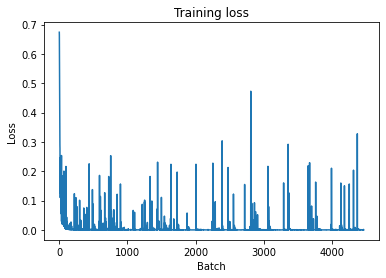

Loss на обучающей выборке: 0.00598


In [ ]:
from IPython.display import clear_output

# Будем сохранять loss во время обучения
# и рисовать график в режиме реального времени
train_loss_set = []
train_loss = 0


# Обучение
# Переводим модель в training mode
model.train()


for step, batch in enumerate(train_dataloader):
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # если не сделать .zero_grad(), градиенты будут накапливаться
    optimizer.zero_grad()
    
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

    train_loss_set.append(loss[0].item())  
    
    # Backward pass
    loss[0].backward()
    
    # Обновляем параметры и делаем шаг используя посчитанные градиенты
    optimizer.step()

    # Обновляем loss
    train_loss += loss[0].item()
    
    # Рисуем график
    clear_output(True)
    plt.plot(train_loss_set)
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()
    
print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))

# Валидация
model.eval()

valid_preds, valid_labels = [], []

for batch in validation_dataloader:   
    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)     
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

In [ ]:
from sklearn.metrics import accuracy_score
print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

Процент правильных предсказаний на валидационной выборке: 99.97%


## Протестируем модель

In [ ]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(
    input_ids,
    maxlen=100,
    dtype="long",
    truncating="post",
    padding="post"
)

In [ ]:
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_gt)

prediction_data = TensorDataset(
    prediction_inputs,
    prediction_masks,
    prediction_labels
)

prediction_dataloader = DataLoader(
    prediction_data, 
    sampler=SequentialSampler(prediction_data),
    batch_size=32
)

In [ ]:
model.eval()
test_preds, test_labels = [], []

for batch in prediction_dataloader:
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для тестовых данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Сохраняем предсказанные классы и ground truth
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)  
    test_preds.extend(batch_preds)
    test_labels.extend(batch_labels)

In [ ]:
acc_score = accuracy_score(test_labels, test_preds)
print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(
    acc_score*100
))

Процент правильных предсказаний на отложенной выборке составил: 99.98%


### Тесты по заданию

Нужно оценить на 3ёх метриках

Я выбрал

- Precision
- Recall
- Accuracy

In [ ]:
from sklearn.metrics import precision_score, recall_score
accuracy = acc_score*100
precision = precision_score(test_labels, test_preds)
recall = recall_score(test_labels, test_preds)

In [ ]:
accuracy

99.98089668043086

In [ ]:
precision * 100

99.97385696857026

In [ ]:
recall * 100

99.98837918712414